# BrainBuilder Column
This notebook builds a microcircuit using the brainbuilder library and some custom-built atlases to match the existing BBP model.

In [1]:
import numpy as np
import pandas as pd
from voxcell.core import CellCollection, VoxelData, Hierarchy
from voxcell import build, math
from brainbuilder.utils import bbp

%matplotlib inline
from matplotlib import pyplot as plt

from voxcellview.notebook import NotebookViewer

notebook = NotebookViewer('out/hippo_column')

/home/courcol/DEV/BrainBuilder/platform_venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Atlas and Density

Take some data from your standard recipe and mesobuilder configuration to define the size of the hexagon and of the tiling

In [2]:
# data from the recipe:
recipe_filename = "../data/hippo_recipe/builderRecipeAllPathways.xml"
neurondb_filename = "../data/hippo_recipe/v4neuronDB.dat"

lattice_vectors = bbp.get_lattice_vectors(recipe_filename)

layer_thickness_microns = bbp.get_layer_thickness(recipe_filename)

# data from the O1 meso_conf.yaml
mosaic_n1 = 3
mosaic_n2 = 3
mosaic_coords_mask = [(0, 0), (0, 2)]

Build a custom hierarchy

In [3]:
hierarchy = Hierarchy({
    'name': 'root',
    'id': 999,
    'children': [
            {'name': 'Pia', 'id': 0},
            {'name': 'Hippocampus Fissure (HF) - Layer 1', 'id': 1},
            {'name': 'Stratum Lacunosum-moleculare (SLM) - Layer 2', 'id': 2},
            {'name': 'Stratum Radiatum (SR) - Layer 3', 'id': 3},
            {'name': 'Stratum Pyramidale (SP) - Layer 4', 'id': 4},
            {'name': 'Stratum Oriens (SO) - Layer 5', 'id': 5},
            {'name': 'Alveus (AL) - Layer 6', 'id': 6},
        ]
    })

Note that we want our atlas to contain a bit of space tagged as "outside the brain". This will later be used to compute "distance to pia" for placement hints.

In [4]:
layer_thickness_microns[0] = 15  # PIA

In [5]:
layer_ids, heights_microns = zip(*sorted(layer_thickness_microns.items(), lambda l, _: -l[0]))

hexagon_side = np.sqrt(np.sum(np.square(lattice_vectors['a1'])))

Convert from microns to number of voxels

In [6]:
voxel_side_microns = build.get_voxel_side(heights_microns)

heights = np.round(np.array(heights_microns) / voxel_side_microns).astype(np.uint)
max_width = np.round(np.array(3 * 2 * hexagon_side) / voxel_side_microns).astype(np.uint)

Build a custom annotation

In [7]:
annotation = VoxelData(build.layered_annotation((max_width, max_width), heights, layer_ids),
                       [voxel_side_microns] * 3)
notebook.show_volume('annotation', annotation)

Build the single column mask

In [8]:
hexagon_mask = build.regular_convex_polygon_mask_from_side(hexagon_side, 6, voxel_side_microns)

notebook.show_volume('hexagon', np.array([hexagon_mask]))

single_column_mask = build.column_mask(hexagon_mask, length=annotation.raw.shape[1], axis=1)
single_column_mask = math.clip(single_column_mask, math.minimum_aabb(single_column_mask))

Build the mosaic mask

In [9]:
tiling = build.lattice_tiling(mosaic_n1, mosaic_n2,
                                lattice_vectors['a1'] / voxel_side_microns,
                                lattice_vectors['a2'] / voxel_side_microns,
                                mosaic_coords_mask)

mosaic_mask = build.tiled_pattern(hexagon_mask, (np.floor(t).astype(np.int) for t in tiling))
notebook.show_volume('mosaic_mask', np.array([mosaic_mask]))

mosaic_column_mask = build.column_mask(mosaic_mask, length=annotation.raw.shape[1], axis=1)
mosaic_column_mask = math.clip(mosaic_column_mask, math.minimum_aabb(mosaic_column_mask))
notebook.show_volume('mosaic_column_mask', mosaic_column_mask)

Build custom densities using the layer percentages from the recipe and our custom annotation

In [10]:
full_density = bbp.load_recipe_density(recipe_filename, annotation,
                                       {1: (1,), 2: (2,), 3: (3,), 4: (4,), 5: (5,), 6: (6,)})

In [11]:
single_column_density = full_density.clipped(math.minimum_aabb(single_column_mask))
single_column_density.raw *= single_column_mask

In [12]:
mosaic_column_density = full_density.clipped(math.minimum_aabb(mosaic_column_mask))
mosaic_column_density.raw *= mosaic_column_mask

## Circuit Building

In [13]:
total_cell_count = bbp.get_total_neurons(recipe_filename)

In [14]:
from brainbuilder.cell_positioning import cell_positioning
from brainbuilder.assignment_synapse_class import assign_synapse_class_from_spatial_dist
from brainbuilder.assignment_metype import assign_metype
from brainbuilder.assignment_morphology import assign_morphology

In [15]:
region_name = 'root'
recipe_sdist = bbp.load_recipe_as_spatial_distribution(recipe_filename,
                                                       annotation,
                                                       hierarchy,
                                                       region_name)

neuron_sdist = bbp.load_neurondb_v4_as_spatial_distribution(neurondb_filename,
                                                            annotation,
                                                            hierarchy,
                                                            region_name,
                                                            percentile=0.92)

def build_cells(total_cell_count, density):
    '''the standard workflow to build an SSCX circuit'''
    new_cells = CellCollection()

    # Positions
    new_cells.positions = cell_positioning(density, total_cell_count)

    # Excitatory / Inhibitory
    chosen_synapse_class = assign_synapse_class_from_spatial_dist(new_cells.positions, recipe_sdist)
    new_cells.add_properties(chosen_synapse_class)

    # MType, EType
    chosen_me = assign_metype(new_cells.positions, new_cells.properties.synapse_class, recipe_sdist)
    new_cells.add_properties(chosen_me)

    # Morphology
    chosen_morphology = assign_morphology(new_cells.positions,
                                          new_cells.properties[['mtype', 'etype']],
                                          neuron_sdist)
    new_cells.add_properties(chosen_morphology)

    # cells.orientations = assign_orientations(cells.positions, orientation_field)

    # layer (for later analysis)
    lid = annotation.lookup(new_cells.positions) - 1
    new_cells.add_properties(pd.DataFrame({'layer': lid}))

    return new_cells

In [16]:
single_columns = [build_cells(total_cell_count, single_column_density) for i in range(7)]
notebook.show_property('mtype', single_columns[0])

In [17]:
mosaic_column_cells = build_cells(7 * total_cell_count, mosaic_column_density)
notebook.show_property('mtype', mosaic_column_cells)

## Analysis

In [18]:
import report

In [19]:
report.check_hexagon_diameter(single_columns, hexagon_side)

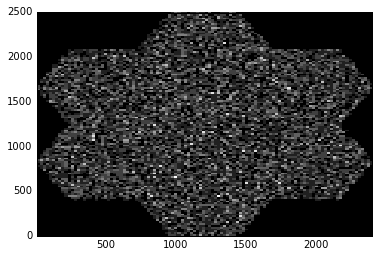

In [20]:
plt.figure()
_ = plt.hist2d(mosaic_column_cells.positions[:, 0],
               mosaic_column_cells.positions[:, 2],
               bins=(110, 120), cmap='binary_r')

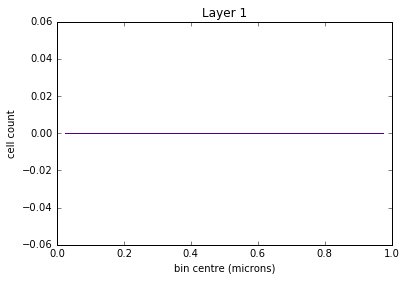

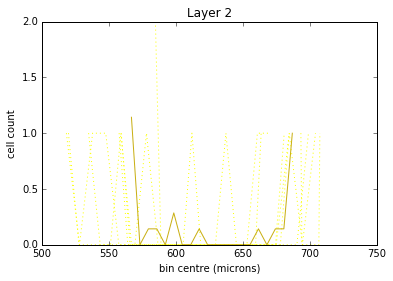

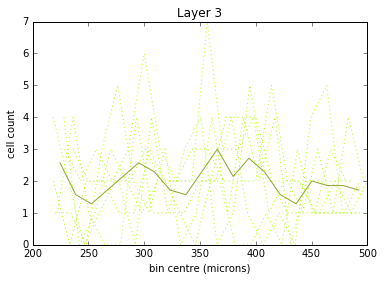

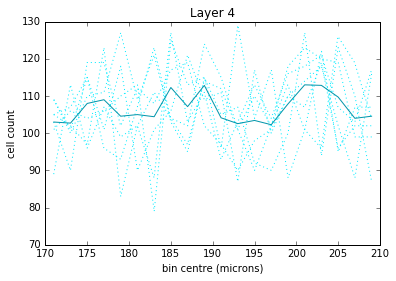

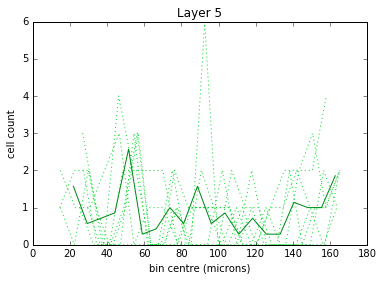

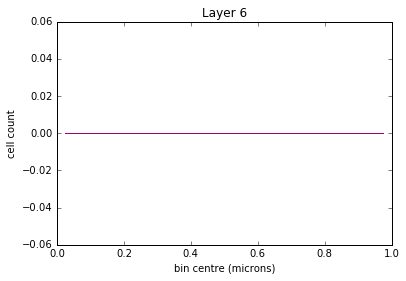

In [21]:
report.report_height_histogram(single_columns)

In [22]:
recipe = bbp.get_distribution_from_recipe(recipe_filename)
recipe.layer -= 1  # in the recipe they are indexed by 1 but in the mvd2 they are by 0

Compare the percentages of cells grouped by layer with the values specified in the recipe.

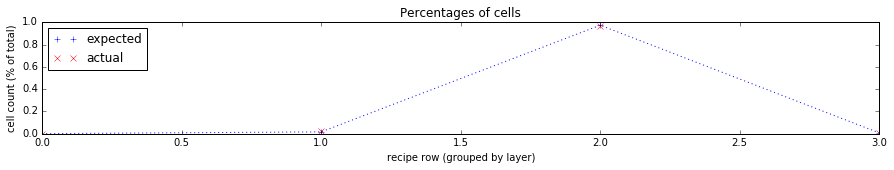

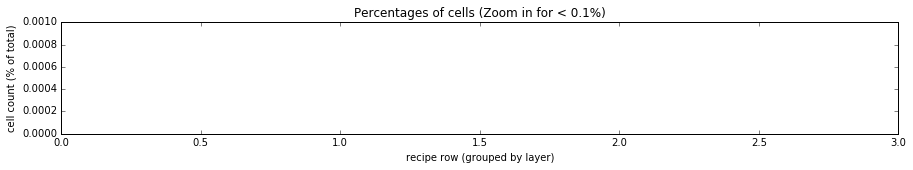

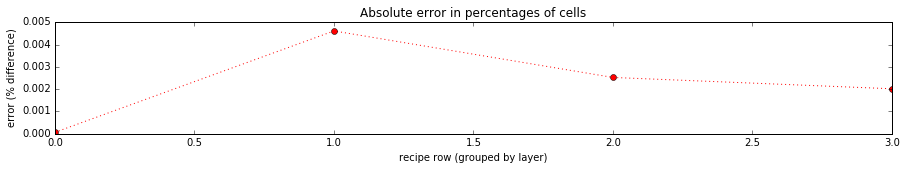

In [23]:
report.report_cell_percentages(recipe, [single_columns[0]], ['layer'])

Compare the percentages of cells grouped by layer-mtype-etype with the values specified in the recipe.

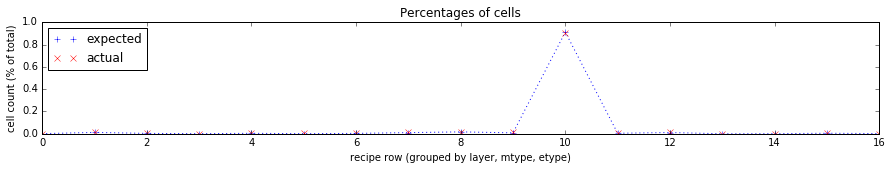

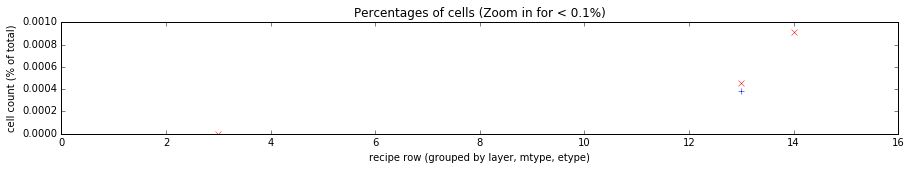

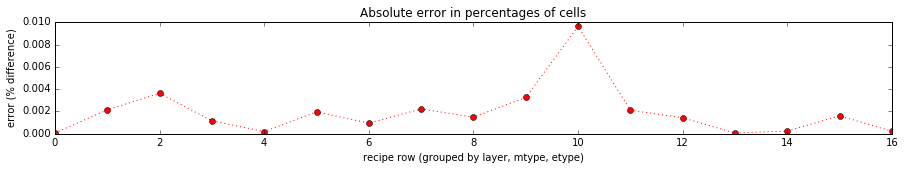

In [24]:
report.report_cell_percentages(recipe, [single_columns[0]], ['layer', 'mtype', 'etype'])

## Placement hints
Look at cells without valid morphologies, check that they belong to mtypes for which some placement hint scores are zero

In [25]:
neurondb = bbp.load_neurondb_v4(neurondb_filename)
neurondb.layer -= 1  # in the neurondb they are indexed by 1 but in the mvd2 they are by 0

In [26]:
hints = report.collect_placement_hints(neurondb)
for c in single_columns + [mosaic_column_cells]:
    report.check_bad_bins(hints, c)